### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [112]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import pathlib
import pyproj
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [12]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [16]:
def load_bedmap_ll(filepath):
    data = pd.read_csv(filepath, skiprows=18)

    lon_index = [col for col in data.columns if 'longitude' in col][0]
    lat_index = [col for col in data.columns if 'latitude' in col][0]
    lon = data[lon_index]
    lat = data[lat_index]

    return lon, lat

In [17]:
def load_bedmap_xy(filepath):
    data = pd.read_csv(filepath, skiprows=18)

    lon_index = [col for col in data.columns if 'longitude' in col][0]
    lat_index = [col for col in data.columns if 'latitude' in col][0]
    lon = data[lon_index]
    lat = data[lat_index]
    ps71=pyproj.Proj('epsg:3031')
    xx, yy = ps71.transform(lon, lat)

    return xx, yy

In [344]:
def find_closest_bedmap(survey_xx, survey_yy, subsampling, bm1_xx, bm1_yy):
    """
    For every N-th point in the input survey, find the closest point in BM1.
    """
    survey_idxs = np.arange(0, len(survey_xx), subsampling)
    survey_idxs = np.append(survey_idxs, len(survey_xx) - 1)
    min_bm1_idxs = -1 * np.ones(survey_idxs.shape)
    for idx, survey_idx in enumerate(survey_idxs):
        dx = np.abs(bm1_xx - survey_xx[survey_idx])
        dy = np.abs(bm1_yy - survey_yy[survey_idx])
        dists = np.sqrt(dx*dx + dy*dy)
        min_bm1_idxs[idx] = np.argmin(dists)
    # Need array of ints to use as indices
    min_bm1_idxs = [int(el) for el in min_bm1_idxs]
    return np.array(min_bm1_idxs)
    

In [403]:
def expand_range(group_idxs, survey_xx, survey_yy, bm1_xx, bm1_yy, tolerance=10000):
    """
    Our calculated range may miss a few points from the BEDMAP1 dataset, so see if we
    can extend along those indexes while being close to the input survey.
    
    * group_idxs: indices into bm1 that are definitely in the survey
    * tolerance: distance in meters to consider BM1 point matching the survey
         (This doesn't seem to need to be very precise since the BEDMAP1 points
         are generally contiguous within a survey, so the next survey is likely
         to be a large jump.)
    """
    min_dist = 0
    group_start = min(group_idxs)
    while min_dist < tolerance: 
        group_start -= 1
        if group_start < 0:
            break
        dx = np.abs(bm1_xx[group_start] - survey_xx)
        dy = np.abs(bm1_yy[group_start] - survey_yy)
        dists = np.sqrt(dx*dx + dy*dy)
        min_dist = np.min(dists)
    
    print("For BM1 idx {}, min_dist = {:0.2f} km".format(group_start, min_dist/1000))
    group_start += 1  # This is ugly, but the while loop terminated with group1_start just outside of range.

    group_end = max(group_idxs)
    min_dist = 0
    while min_dist < tolerance: 
        group_end += 1
        if group_end >= len(bm1_xx):
            break
        dx = np.abs(bm1_xx[group_end] - survey_xx)
        dy = np.abs(bm1_yy[group_end] - survey_yy)
        dists = np.sqrt(dx*dx + dy*dy)
        min_dist = np.min(dists)
    print("For BM1 idx {}, min_dist = {:0.2f} km".format(group_end, min_dist/1000))
    group_end -= 1
    
    return group_start, group_end


In [19]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

## UTIG

* The IRE survey made it into BEDMAP1 (And shows up attributed to UTIG in BEDMAP2)

1991_CASERTZ is the equivalent survey in the BEDMAP2 dataset.

However, it ALSO shows up in the 1999 SOAR grouping with other WAIS surveys, but with slightly different positioning data for each point. (The BEDMAP1 points appear to exactly match 1991_CASERTZ).


In [293]:
ire_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/UTIG_1991_CASERTZ_AIR_BM2.csv"
ire_lon, ire_lat = load_bedmap_ll(ire_path)
ire_xx, ire_yy = load_bedmap_xy(ire_path)

In [294]:
min_bm1_idxs = find_closest_bedmap(ire_xx, ire_yy, 100, bm1_xx, bm1_yy)

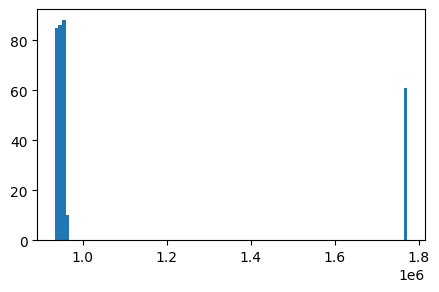

In [295]:
# Let's check the distribution of these closest points
fig = plt.figure(figsize=(5,3))
ax = fig.subplots(1,1)
ax.hist(min_bm1_idxs, bins=100);

The above histogram showed that there are two separate populations 
of points in BEDMAP1 corresponding to this survey


In [296]:
group1_idxs, = np.where(np.array(min_bm1_idxs) < 1000000)
group1_idxs = np.array(min_bm1_idxs)[group1_idxs]

group2_idxs, = np.where(np.array(min_bm1_idxs) > 1000000)
group2_idxs = np.array(min_bm1_idxs)[group2_idxs]

group1_range = np.arange(np.min(group1_idxs), np.max(group1_idxs))
group2_range = np.arange(np.min(group2_idxs), np.max(group2_idxs))

In [297]:
len(ire_xx), len(group1_range) + len(group2_range)

(32812, 32770)

If we assume a one-to-one mapping of points from the BEDMAP2 dataset to BEDMAP1, we're missing a handful of points. Let's try searching outward from both sides of the groups until points are out-of-range.

In [310]:
# See about extending the bedmap range a bit, in case we missed any
group1_start, group1_end = expand_range(group1_idxs, ire_xx, ire_yy, bm1_xx, bm1_yy, 10000)
group2_start, group2_end = expand_range(group2_idxs, ire_xx, ire_yy, bm1_xx, bm1_yy, 10000)
group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
group2_range = np.arange(group2_start, group2_end+1) 

For BM1 idx 895838, min_dist = 1876.81 km
For BM1 idx 934047, min_dist = 1844.90 km
For BM1 idx 1755860, min_dist = 1718.19 km
For BM1 idx 1766199, min_dist = 1950.84 km


In [300]:
# Assuming the datapoints in BEDMAP2 are one-to-one with those in BEDMAP1, check if we got 'em all:
len(ire_xx), len(group1_range) + len(group2_range)

(32812, 32813)

OK, we're within one datapoint, call that good enough.


Text(0.5, 1.0, 'BEDMAP1: 1766287 - 1772888')

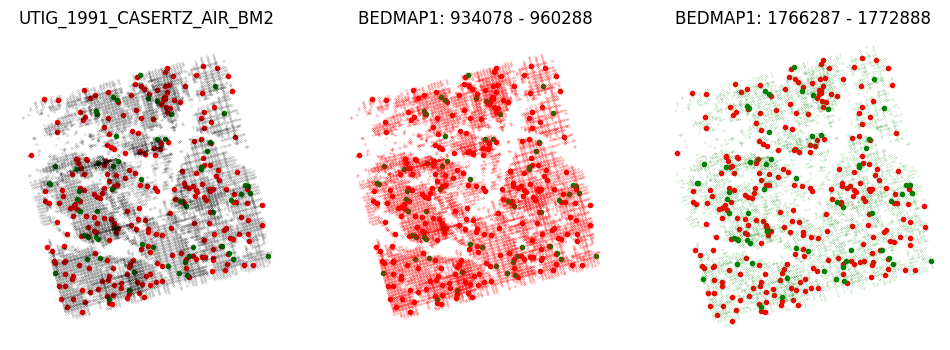

In [302]:
# Confirm that our continguous ranges of points are likely to correspond to this survey
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3, = fig.subplots(1,3)
#ax.plot(gl_xx, gl_yy, '.', color='grey', markersize=0.5)
for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.axis('off')
    ax.plot(bm1_xx[group1_idxs], bm1_yy[group1_idxs], 'r.')
    ax.plot(bm1_xx[group2_idxs], bm1_yy[group2_idxs], 'g.')
ax1.plot(ire_xx, ire_yy, 'k.', markersize = 0.1)
ax1.set_title(pathlib.Path(ire_path).stem)
ax2.plot(bm1_xx[group1_range], bm1_yy[group1_range], 'r.', markersize=0.2)
ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
ax3.plot(bm1_xx[group2_range], bm1_yy[group2_range], 'g.', markersize=0.2)
ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

Text(0.5, 1.0, 'BEDMAP1: 1766287 - 1772888')

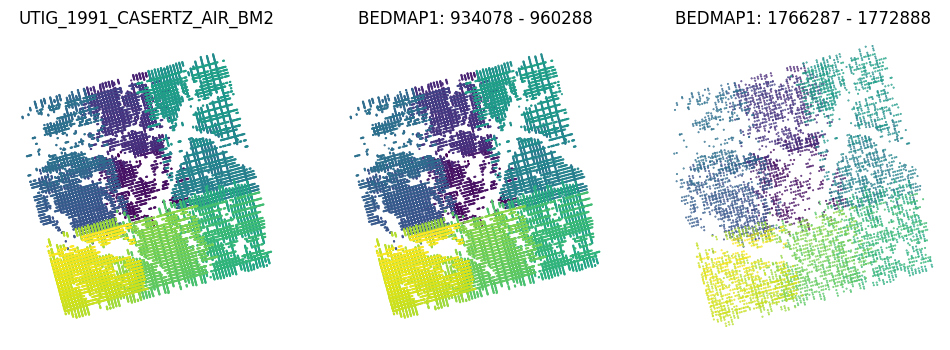

In [303]:
# Let's confirm that the points are organized in some sort of order
# It looks like there are two groupings of points in BEDMAP1 that correspond to the IRE dataset.
# Both of them are contiguous.
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3, = fig.subplots(1,3)
#ax.plot(gl_xx, gl_yy, '.', color='grey', markersize=0.5)
for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.axis('off')
ax1.scatter(ire_xx, ire_yy, c=np.arange(0,len(ire_xx)), edgecolors=None, s=0.3)
ax1.set_title(pathlib.Path(ire_path).stem)
ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

In [221]:
print("The {} survey includes {}-{} and {}-{}".format(pathlib.Path(ire_path).stem, group1_start, group1_end, group2_start, group2_end))

The UTIG_1991_CASERTZ_AIR_BM2 survey includes 934078-960288 and 1766287-1772888


In [304]:
print("The {} survey includes {}-{} and {}-{}".format(pathlib.Path(ire_path).stem, group1_start, group1_end, group2_start, group2_end))

The UTIG_1991_CASERTZ_AIR_BM2 survey includes 934078-960288 and 1766287-1772888


The above ranges have been manually copied into extract_bedmap_tracks as indices to omit in the BEDMAP1 layer.

## AWI

* The 1994 - 1998 DML1 - DML5 surveys are in both Bedmap1 and Bedmap2.

In [323]:
duplicate_awi_surveys = ["AWI_1994_DML1_AIR_BM2", "AWI_1995_DML2_AIR_BM2", 
                         "AWI_1996_DML3_AIR_BM2", "AWI_1997_DML4_AIR_BM2", 
                         "AWI_1998_DML5_AIR_BM2"]

In [345]:
dml_xx = {}
dml_yy = {}
dml_bm1_idxs = {}

for idx, survey in enumerate(duplicate_awi_surveys):
    dml_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/{}.csv".format(survey)
    dml_xx[survey], dml_yy[survey] = load_bedmap_xy(dml_path)
    skip = 50  # TODO: It might be better to run the 200m subsampling.
    dml_bm1_idxs[survey] = find_closest_bedmap(dml_xx[survey], dml_yy[survey], skip, bm1_xx, bm1_yy)    

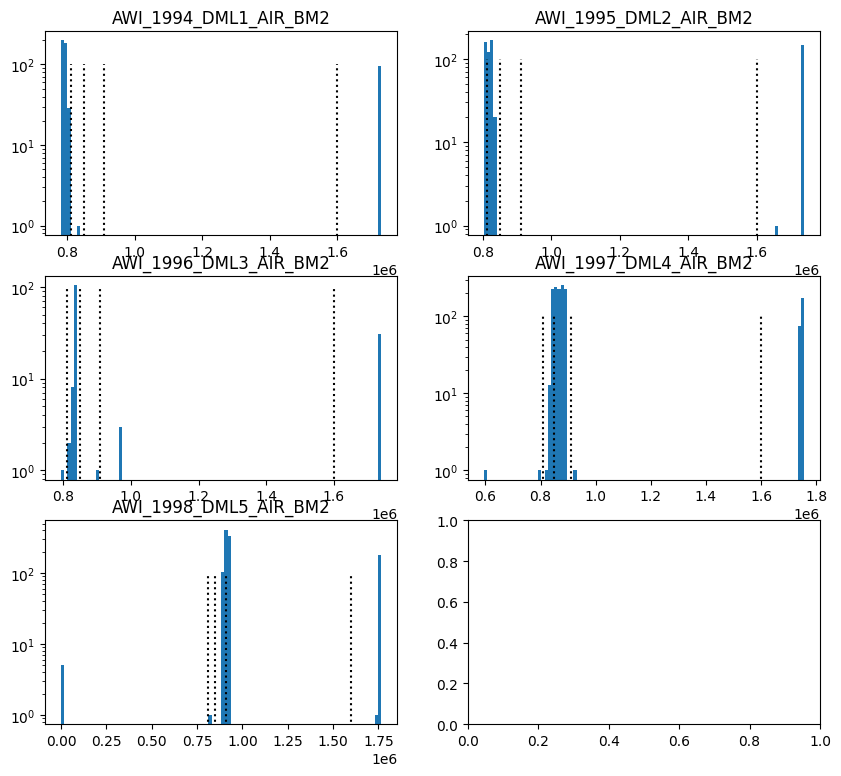

In [346]:
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([8.1e5, 8.5e5, 9.1e5, 1.6e6], 0, 100, linestyle='dotted', colors='black')
    

This is messier for 1996-1998 -- rather than 2 groups, it looks like there may be additional surveys that crossed over the main one and had a few close points.

And, the histogram for the first main cluster aren't detailed enough to select the proper bounds. So, zooming in ...

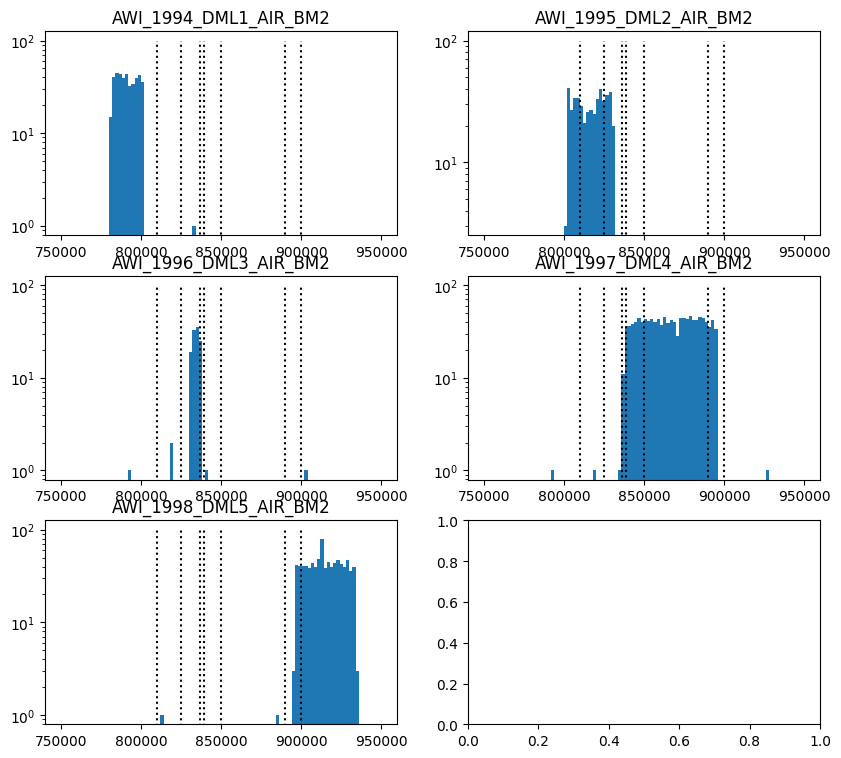

In [357]:
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], range=(7.5e5, 9.5e5), bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([8.1e5, 8.25e5, 8.365e5, 8.39e5, 8.5e5, 8.9e5, 9e5], 0, 100, linestyle='dotted', colors='black')


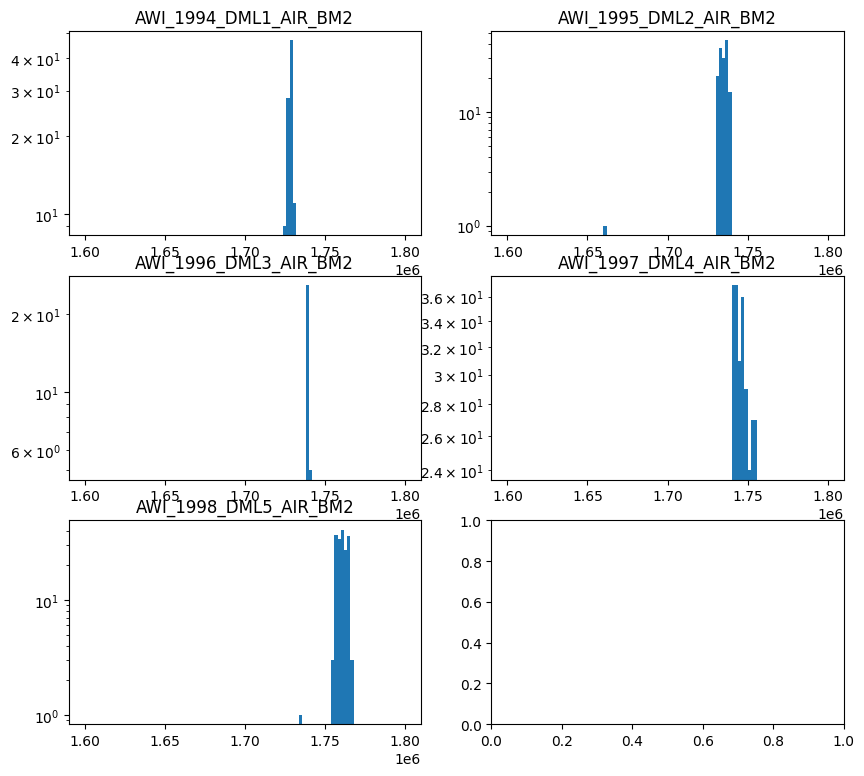

In [358]:
# when decreasing skip from 100 to 50, I needed to look even more closely at the histograms.
fig = plt.figure(figsize=(10,9))
axs = fig.subplots(3,2)

for idx, survey in enumerate(duplicate_awi_surveys):
    # Let's check the distribution of these closest points
    ii = int(np.floor(idx/2))
    jj = idx%2
    ax = axs[ii][jj]
    ax.hist(dml_bm1_idxs[survey], range=(1.6e6, 1.8e6), bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([], 0, 100, linestyle='dotted', colors='black')


In [359]:
# Selecting these by hand while exploring the data. 
# If this is a common problem in other datasets, could pick two largest clusters.
awi_survey_bounds = {}
awi_survey_bounds["AWI_1994_DML1_AIR_BM2"] = (-np.inf, 8.1e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1995_DML2_AIR_BM2"] = (-np.inf, 1e6, 1.7e6, np.inf)
awi_survey_bounds["AWI_1996_DML3_AIR_BM2"] = (8.25e5, 8.39e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1997_DML4_AIR_BM2"] = (8.365e5, 9e5, 1.7e6, np.inf)
awi_survey_bounds["AWI_1998_DML5_AIR_BM2"] = (8.9e5, 9.5e5, 1.75e6, np.inf)

In [375]:
awi_survey_ranges = {}
for idx, survey in enumerate(duplicate_awi_surveys):
    min1, max1, min2, max2 = awi_survey_bounds[survey]
    
    i1, = np.where(min1 < dml_bm1_idxs[survey])
    i2, = np.where(dml_bm1_idxs[survey] < max1)
    group1_idxs = np.intersect1d(i1, i2)
    group1_idxs = np.array(dml_bm1_idxs[survey])[group1_idxs]

    i1, = np.where(min2 < dml_bm1_idxs[survey])
    i2, = np.where(dml_bm1_idxs[survey] < max2)
    group2_idxs = np.intersect1d(i1, i2)
    group2_idxs = np.array(dml_bm1_idxs[survey])[group2_idxs]

    # See about extending the bedmap range a bit, in case we missed any
    radius = 10000
    group1_start, group1_end = expand_range(group1_idxs, dml_xx[survey], dml_yy[survey], bm1_xx, bm1_yy, radius)
    group2_start, group2_end = expand_range(group2_idxs, dml_xx[survey], dml_yy[survey], bm1_xx, bm1_yy, radius)
    
    group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
    group2_range = np.arange(group2_start, group2_end+1) 
    awi_survey_ranges[survey] = (group1_range, group2_range)
    
    print("For {}, {} orig points, {} + {} = {} BM1 points"
          .format(survey, len(dml_xx[survey]), len(group1_range), len(group2_range), 
                  len(group1_range) + len(group2_range)))

For BM1 idx 781378, min_dist = 1862.53 km
For BM1 idx 801918, min_dist = 896.03 km
For BM1 idx 1725225, min_dist = 1889.70 km
For BM1 idx 1730676, min_dist = 896.30 km
For AWI_1994_DML1_AIR_BM2, 25257 orig points, 20539 + 5450 = 25989 BM1 points
For BM1 idx 801917, min_dist = 340.73 km
For BM1 idx 831197, min_dist = 53.36 km
For BM1 idx 1730675, min_dist = 349.12 km
For BM1 idx 1738607, min_dist = 51.97 km
For AWI_1995_DML2_AIR_BM2, 30600 orig points, 29279 + 7931 = 37210 BM1 points
For BM1 idx 831196, min_dist = 336.73 km
For BM1 idx 837312, min_dist = 12.72 km
For BM1 idx 1738667, min_dist = 10.12 km
For BM1 idx 1740273, min_dist = 12.05 km
For AWI_1996_DML3_AIR_BM2, 7486 orig points, 6115 + 1605 = 7720 BM1 points
For BM1 idx 837308, min_dist = 203.48 km
For BM1 idx 895839, min_dist = 151.66 km
For BM1 idx 1740271, min_dist = 203.48 km
For BM1 idx 1755842, min_dist = 150.85 km
For AWI_1997_DML4_AIR_BM2, 71905 orig points, 58530 + 15570 = 74100 BM1 points
For BM1 idx 895428, min_dist 

It's a bit odd that the BEDMAP1 dataset has more points, and more dense bed picks, than the BEDMAP2 surveys. 

The AWI_1994_DML1_AIR_BM2 survey includes 781379-801917 and 1725226-1730675
The AWI_1995_DML2_AIR_BM2 survey includes 801918-831196 and 1730676-1738606
The AWI_1996_DML3_AIR_BM2 survey includes 831197-837311 and 1738668-1740272
The AWI_1997_DML4_AIR_BM2 survey includes 837309-895838 and 1740272-1755841
The AWI_1998_DML5_AIR_BM2 survey includes 895429-934046 and 1755734-1766275


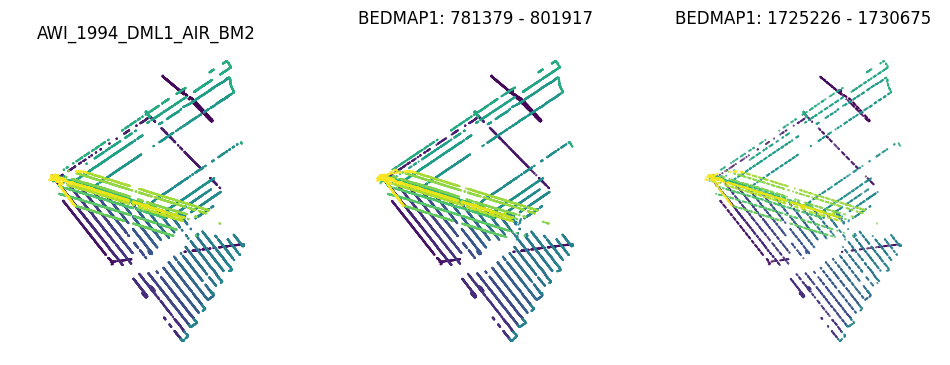

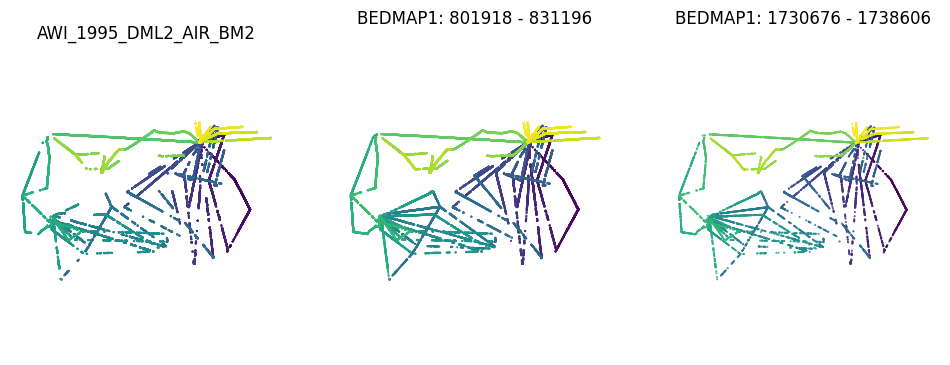

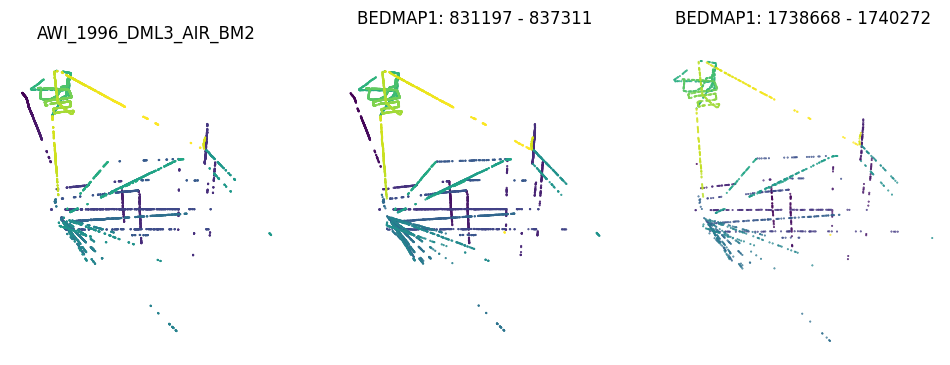

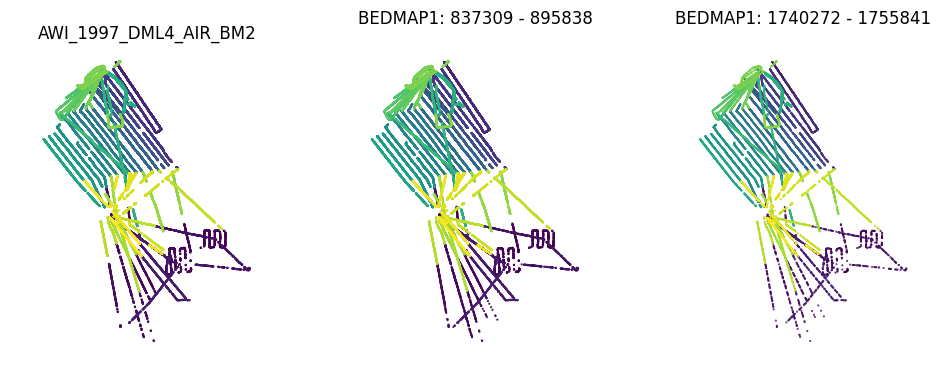

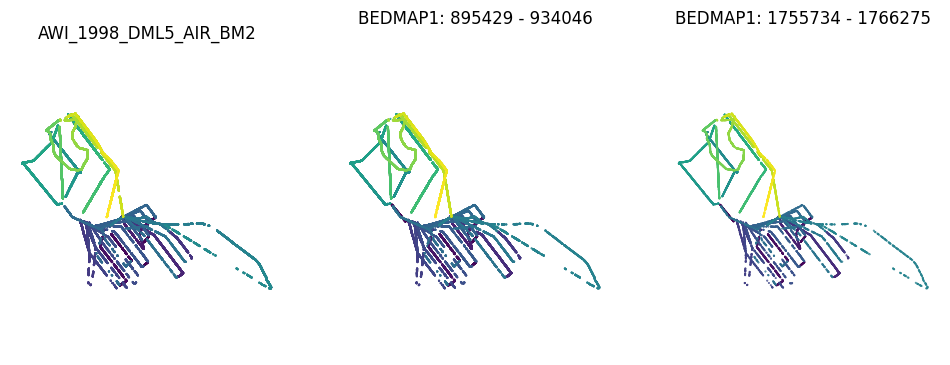

In [376]:
for survey in duplicate_awi_surveys:
    group1_range, group2_range = awi_survey_ranges[survey]
    print("The {} survey includes {}-{} and {}-{}".format(survey, np.min(group1_range), np.max(group1_range), 
                                                          np.min(group2_range), np.max(group2_range)))
    
    fig = plt.figure(figsize=(12,4))
    ax1, ax2, ax3, = fig.subplots(1,3)
    for ax in [ax1, ax2, ax3]:
        ax.axis('equal') 
        ax.axis('off')
    ax1.scatter(dml_xx[survey], dml_yy[survey], c=np.arange(0,len(dml_xx[survey])), edgecolors=None, s=0.3)
    ax1.set_title(survey)
    
    ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
    #ax2.scatter(bm1_xx[group1_idxs], bm1_yy[group1_idxs], c=group1_idxs, edgecolors=None, s=0.3)
    ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
     
    ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
    #ax3.scatter(bm1_xx[group2_idxs], bm1_yy[group2_idxs], c=group2_idxs, edgecolors=None, s=0.2)
    ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

From the above output:

The AWI_1994_DML1_AIR_BM2 survey includes 781379-801917 and 1725226-1730675
The AWI_1995_DML2_AIR_BM2 survey includes 801918-831196 and 1730676-1738606
The AWI_1996_DML3_AIR_BM2 survey includes 831197-837311 and 1738775-1740272
The AWI_1997_DML4_AIR_BM2 survey includes 837309-895838 and 1740272-1755841
The AWI_1998_DML5_AIR_BM2 survey includes 895429-934046 and 1755734-1766275

These are largely sequential, though there is some overlap between 3->4 and 4->5. That's fine, and makes sense if they were taking off from the same airfield.

I'm more curious about the lack of overlap from 2->3: 1_738_606 -> 1_738_775


Text(0.5, 1.0, 'AWI_1996_DML3_AIR_BM2')

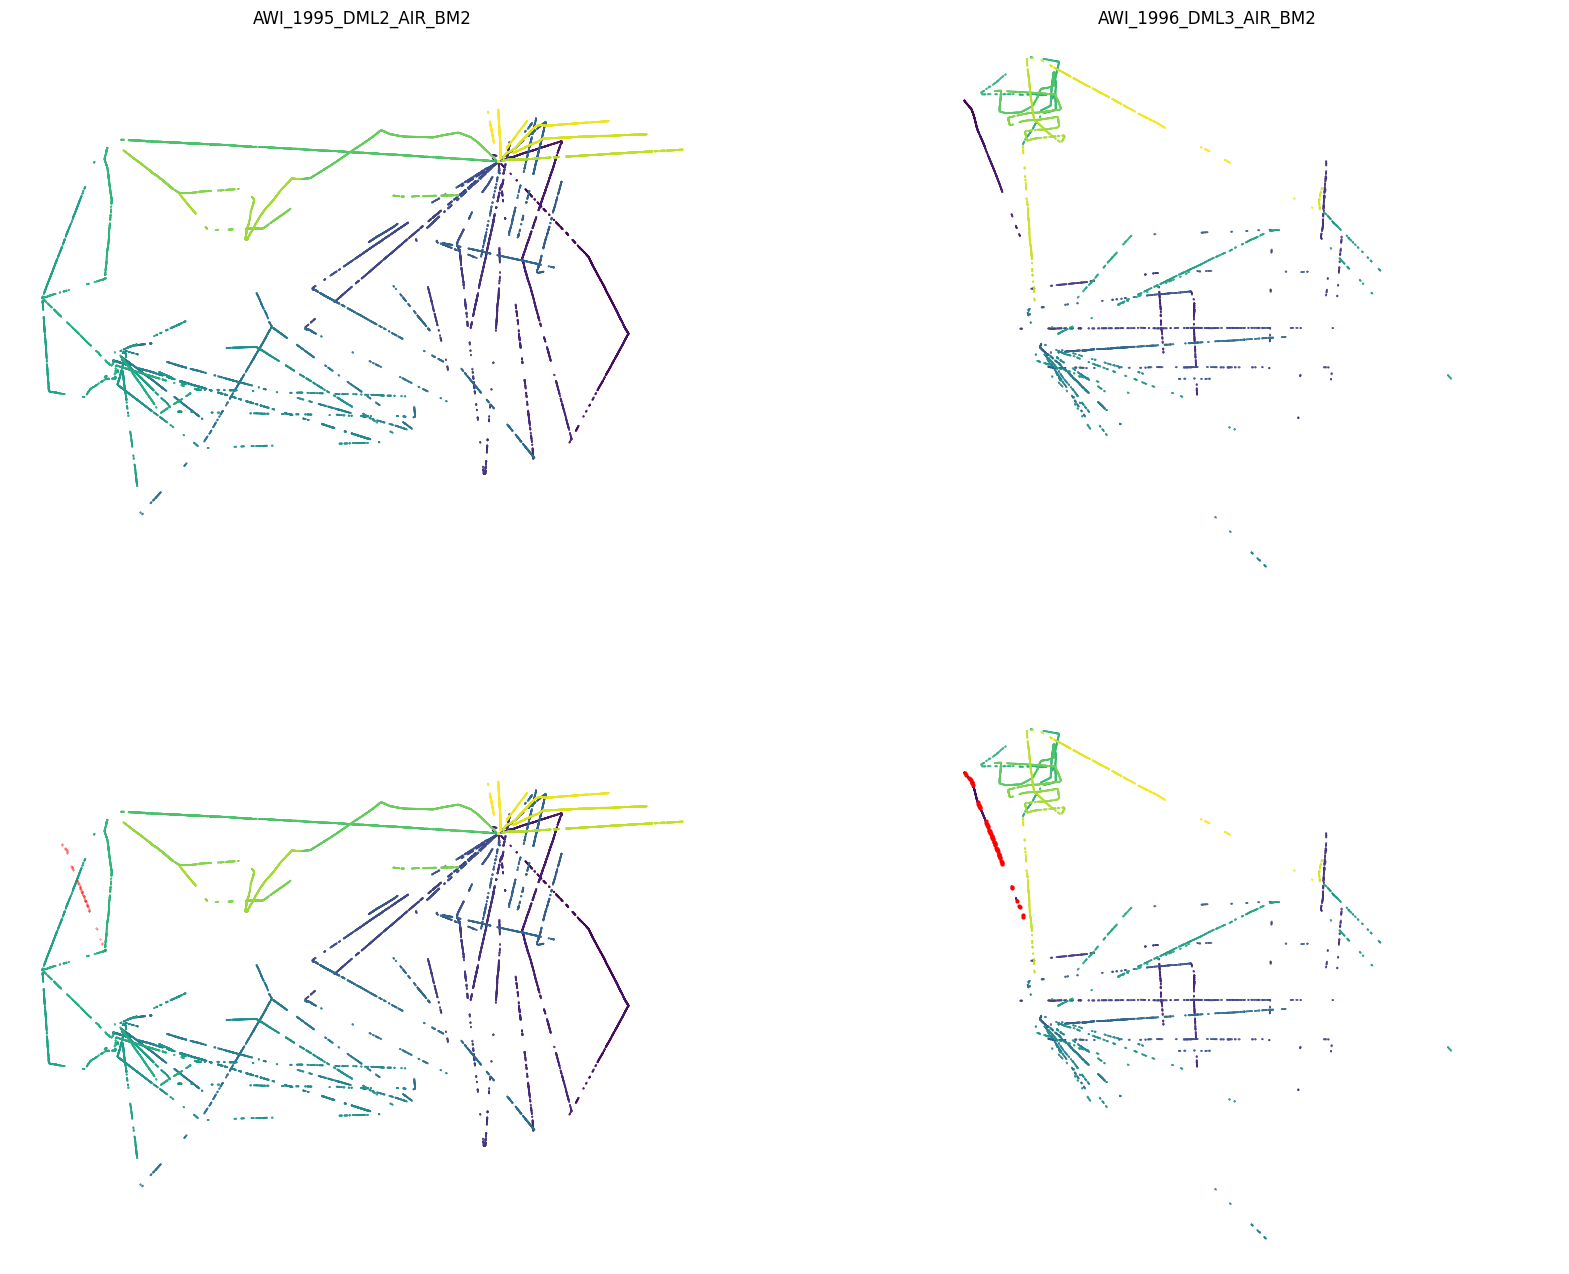

In [374]:
s2 = "AWI_1995_DML2_AIR_BM2"
s3 = "AWI_1996_DML3_AIR_BM2"
# The rest look like they're part of DML3.
missing_range = np.arange(1_738_607, 1_738_668+1)

fig = plt.figure(figsize=(20,16))
[ax1, ax2], [ax3, ax4] = fig.subplots(2,2)
for ax in [ax1, ax2, ax3, ax4]:
    ax.axis('equal') 
    ax.axis('off')
ax1.scatter(dml_xx[s2], dml_yy[s2], c=np.arange(0,len(dml_xx[s2])), edgecolors=None, s=0.1)
ax3.scatter(dml_xx[s2], dml_yy[s2], c=np.arange(0,len(dml_xx[s2])), edgecolors=None, s=0.1)
ax3.plot(bm1_xx[missing_range], bm1_yy[missing_range], 'r.', markersize=0.5)

ax1.set_title(s2)

ax2.scatter(dml_xx[s3], dml_yy[s3], c=np.arange(0,len(dml_xx[s3])), edgecolors=None, s=0.1)
ax4.scatter(dml_xx[s3], dml_yy[s3], c=np.arange(0,len(dml_xx[s3])), edgecolors=None, s=0.1)
ax4.plot(bm1_xx[missing_range], bm1_yy[missing_range], 'r.', markersize=4)
ax2.set_title(s3)



Those points look like they should've been part of DML3, but there was a slight discrepancy between points submitted to BEDMAP1 and BEDMAP2. I'll manually update the bounds to include those.

#### BAS

Two surveys in both BM1 and BM2:
* 1994_Evans
* 1998_Dufek

In [390]:
duplicate_bas_surveys = ["BAS_1994_Evans_AIR_BM2", "BAS_1998_Dufek_AIR_BM2"]

In [391]:
bas_xx = {}
bas_yy = {}
bas_bm1_idxs = {}

for idx, survey in enumerate(duplicate_bas_surveys):
    bas_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/{}.csv".format(survey)
    bas_xx[survey], bas_yy[survey] = load_bedmap_xy(bas_path)
    skip = 50 
    bas_bm1_idxs[survey] = find_closest_bedmap(bas_xx[survey], bas_yy[survey], skip, bm1_xx, bm1_yy)    

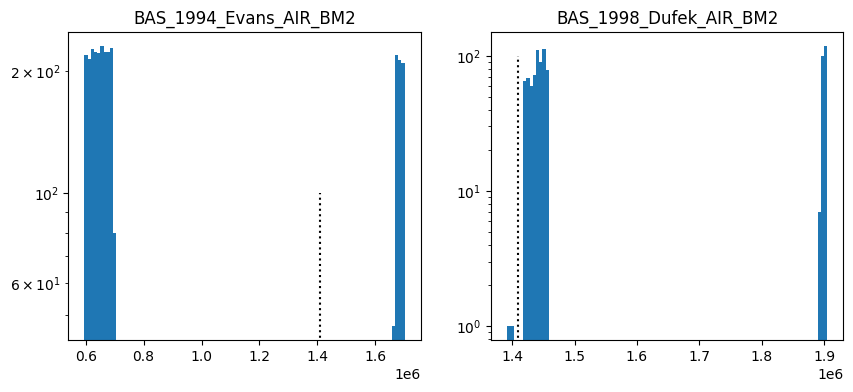

In [396]:
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(1,2)

for idx, survey in enumerate(duplicate_bas_surveys):
    ax = axs[idx]
    ax.hist(bas_bm1_idxs[survey], bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([1.41e6], 0, 100, linestyle='dotted', colors='black')
    

In [400]:
# Selecting these by hand while exploring the data. 
# If this is a common problem in other datasets, could pick two largest clusters.
bas_survey_bounds = {}
bas_survey_bounds["BAS_1994_Evans_AIR_BM2"] = (5e5, 8e5, 1.6e6, 1.8e6)
bas_survey_bounds["BAS_1998_Dufek_AIR_BM2"] = (1.41e6, 1.5e6, 1.85e6, 1.95e6)


In [407]:
bas_survey_ranges = {}
for idx, survey in enumerate(duplicate_bas_surveys):
    min1, max1, min2, max2 = bas_survey_bounds[survey]
    
    i1, = np.where(min1 < bas_bm1_idxs[survey])
    i2, = np.where(bas_bm1_idxs[survey] < max1)
    group1_idxs = np.intersect1d(i1, i2)
    group1_idxs = np.array(bas_bm1_idxs[survey])[group1_idxs]

    i1, = np.where(min2 < bas_bm1_idxs[survey])
    i2, = np.where(bas_bm1_idxs[survey] < max2)
    group2_idxs = np.intersect1d(i1, i2)
    group2_idxs = np.array(bas_bm1_idxs[survey])[group2_idxs]

    # See about extending the bedmap range a bit, in case we missed any
    radius = 10000
    group1_start, group1_end = expand_range(group1_idxs, bas_xx[survey], bas_yy[survey], bm1_xx, bm1_yy, radius)
    group2_start, group2_end = expand_range(group2_idxs, bas_xx[survey], bas_yy[survey], bm1_xx, bm1_yy, radius)
    
    group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
    group2_range = np.arange(group2_start, group2_end+1) 
    bas_survey_ranges[survey] = (group1_range, group2_range)
    
    print("For {}, {} orig points, {} + {} = {} BM1 points"
          .format(survey, len(bas_xx[survey]), len(group1_range), len(group2_range), 
                  len(group1_range) + len(group2_range)))

For BM1 idx 595687, min_dist = 1279.30 km
For BM1 idx 699240, min_dist = 3375.41 km
For BM1 idx 1665966, min_dist = 1290.20 km
For BM1 idx 1701480, min_dist = 3373.43 km
For BAS_1994_Evans_AIR_BM2, 139174 orig points, 103552 + 35513 = 139065 BM1 points
For BM1 idx 1418778, min_dist = 2278.20 km
For BM1 idx 1458534, min_dist = 1719.78 km
For BM1 idx 1894447, min_dist = 2280.39 km
For BM1 idx 1905050, min_dist = 0.00 km
For BAS_1998_Dufek_AIR_BM2, 44088 orig points, 39755 + 10602 = 50357 BM1 points


The BAS_1994_Evans_AIR_BM2 survey includes 595688-699239 and 1665967-1701479
The BAS_1998_Dufek_AIR_BM2 survey includes 1418779-1458533 and 1894448-1905049


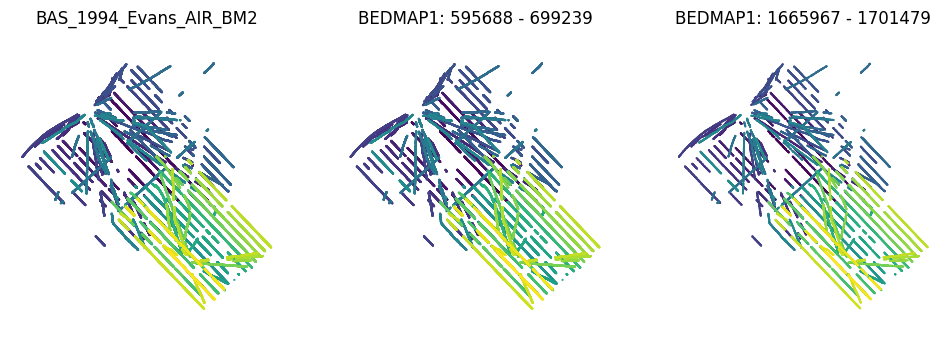

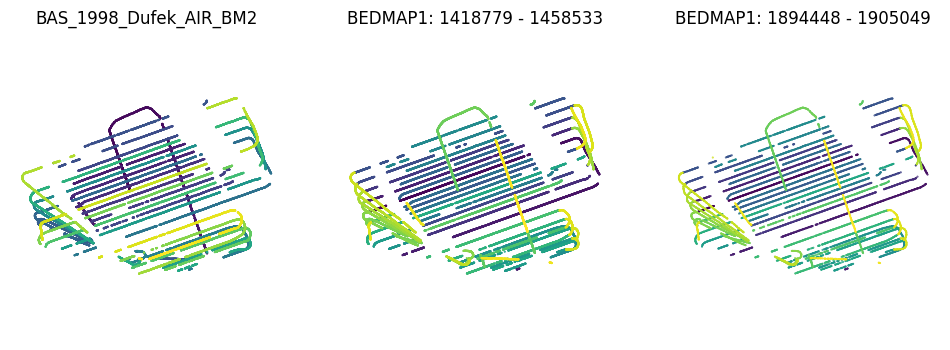

In [408]:
for survey in duplicate_bas_surveys:
    group1_range, group2_range = bas_survey_ranges[survey]
    print("The {} survey includes {}-{} and {}-{}".format(survey, np.min(group1_range), np.max(group1_range), 
                                                          np.min(group2_range), np.max(group2_range)))
    
    fig = plt.figure(figsize=(12,4))
    ax1, ax2, ax3, = fig.subplots(1,3)
    for ax in [ax1, ax2, ax3]:
        ax.axis('equal') 
        ax.axis('off')
    ax1.scatter(bas_xx[survey], bas_yy[survey], c=np.arange(0,len(bas_xx[survey])), edgecolors=None, s=0.3)
    ax1.set_title(survey)
    
    ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
    #ax2.scatter(bm1_xx[group1_idxs], bm1_yy[group1_idxs], c=group1_idxs, edgecolors=None, s=0.3)
    ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
     
    ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
    #ax3.scatter(bm1_xx[group2_idxs], bm1_yy[group2_idxs], c=group2_idxs, edgecolors=None, s=0.2)
    ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

#### INVG

It looks like part of the 1997_Talos-Dome survey is in BM1, but not all

#### NIPR

In both BM1 & BM2:
* 1992_JARE33
* 1996_JARE37

#### RNRF

From the point distribution, I wonder if these are seismic rather than radar. Both appear in BM1 and BM2:
* 1971_Lambert-Amery
* 1975_Filchner-Ronne


#### Stanford/SPRI

It looks like Stanford contributed additional bed picks along some of the old SPRI lines, duplicating what shows up in BM1.